In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import warnings

warnings.filterwarnings('ignore')

Load dataset

In [2]:
data = pd.read_csv('heart.csv')
df = pd.DataFrame(data)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Data analysis
 
Hypothesis: Heart disease affects gender group differently

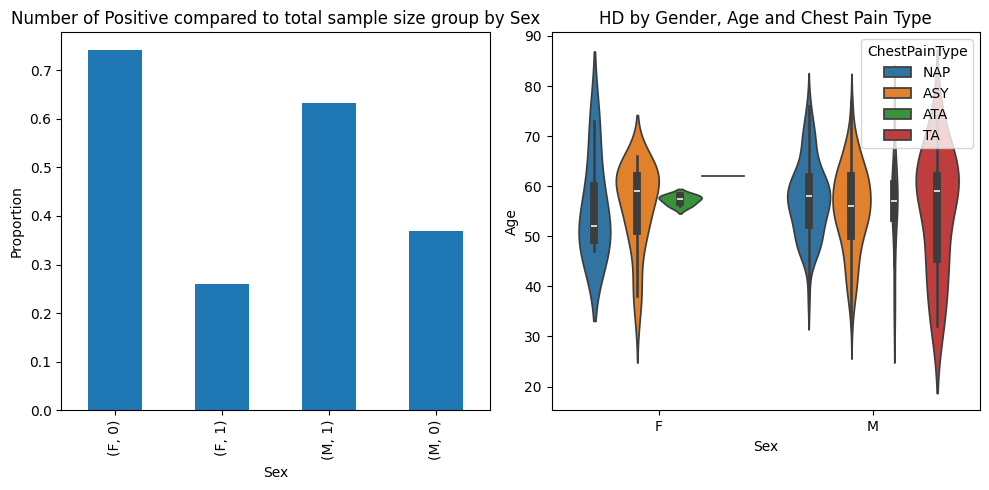

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

#Chart 1: positive by sex
grouped_data = df.groupby('Sex')['HeartDisease'].value_counts(normalize=True)
grouped_data.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_title('Number of Positive compared to total sample size group by Sex')
ax[0].set_xlabel('Sex')
ax[0].set_ylabel('Proportion')

df_positive = df[df['HeartDisease'] == 1]
sns.violinplot(x='Sex', y='Age', data=df_positive, hue='ChestPainType', split=False, ax=ax[1])
ax[1].set_title('HD by Gender, Age and Chest Pain Type')
ax[1].set_xlabel('Sex')
ax[1].set_ylabel('Age')

plt.tight_layout()
plt.show()

Preprocessing data for model

In [4]:
oh_encoder = OneHotEncoder(sparse=False)

for column in df.columns:
   if df[column].dtype == 'object':
      df[column] = oh_encoder.fit_transform(df[column].values.reshape(-1,1))

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    float64
 2   ChestPainType   918 non-null    float64
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    float64
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    float64
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    float64
 11  HeartDisease    918 non-null    int64  
dtypes: float64(6), int64(6)
memory usage: 86.2 KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0.0,0.0,140,289,0,0.0,172,1.0,0.0,0.0,0
1,49,1.0,0.0,160,180,0,0.0,156,1.0,1.0,0.0,1
2,37,0.0,0.0,130,283,0,0.0,98,1.0,0.0,0.0,0
3,48,1.0,1.0,138,214,0,0.0,108,0.0,1.5,0.0,1
4,54,0.0,0.0,150,195,0,0.0,122,1.0,0.0,0.0,0


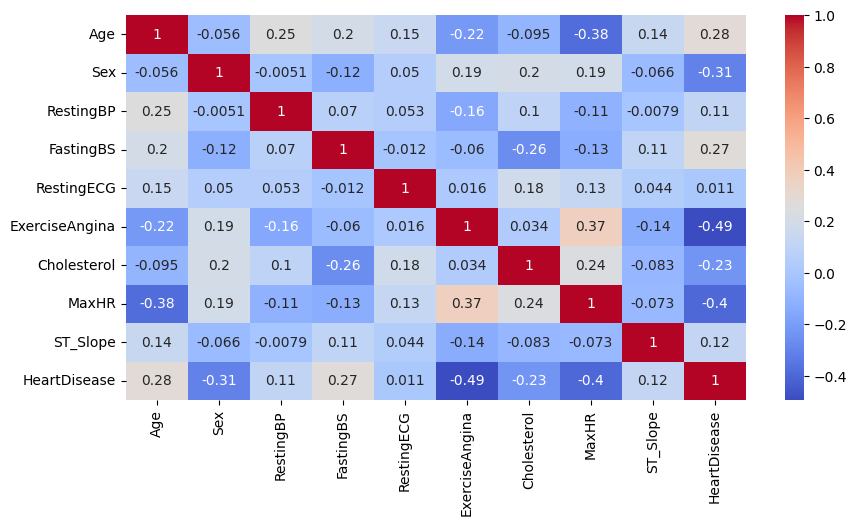

In [5]:
df_copy = df.copy()
corr_matrix = df_copy.corr()

columns_of_interest = ['Age', 'Sex', 'RestingBP', 
                       'FastingBS', 'RestingECG', 'ExerciseAngina',
                       'Cholesterol', 'MaxHR', 'ST_Slope', 'HeartDisease']  # example columns
subset_corr_matrix = df[columns_of_interest].corr()

plt.figure(figsize=(10,5))
sns.heatmap(subset_corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Create Models

In [6]:
# Split the data into training and testing sets
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the models
LR_model = SGDClassifier(loss='log_loss', random_state=42, max_iter=1000,  # Adjust max_iter as needed
                         alpha=0.000001, penalty='l2', l1_ratio=0.1, eta0=0.01,
                         early_stopping=True, validation_fraction=0.2, learning_rate='invscaling')
NB_model = GaussianNB()


Train and evaluate models

In [12]:
# Train the models
LR_model.fit(X_train, y_train)
NB_model.fit(X_train, y_train)

w0 = LR_model.coef_
w1 = LR_model.intercept_

w = np.concatenate((w1.reshape(1,1), w0), axis=1)

print('Logistic Regression Model intercept and parameters:', np.round(w,2))

Logistic Regression Model intercept and parameters: [[ 0.06  0.13 -0.16  0.27  0.06 -0.14  0.13 -0.01 -0.2  -0.26  0.22  0.05]]


In [7]:

# Make predictions on the train data set
LR_model_train_pred = LR_model.predict(X_train)

# Metrics for training data
LR_model_train_accuracy = accuracy_score(y_train, LR_model_train_pred)
LR_model_train_precision = precision_score(y_train, LR_model_train_pred)
LR_model_train_recall = recall_score(y_train, LR_model_train_pred)
LR_model_train_cm = confusion_matrix(y_train, LR_model_train_pred)
LR_model_train_selectivity = LR_model_train_cm[0,0] / (LR_model_train_cm[0,0] + LR_model_train_cm[0,1])
LR_model_train_f1 = f1_score(y_train, LR_model_train_pred)
LR_model_train_log_loss = log_loss(y_train, LR_model.predict_proba(X_train))

# Evaluate the models
LR_model_pred = LR_model.predict(X_test)
NB_model_pred = NB_model.predict(X_test)

# Calculate metrics
LR_model_accuracy = accuracy_score(y_test, LR_model_pred)
NB_model_accuracy = accuracy_score(y_test, NB_model_pred)

LR_model_precision = precision_score(y_test, LR_model_pred)
NB_model_precision = precision_score(y_test, NB_model_pred)

LR_model_recall = recall_score(y_test, LR_model_pred)
NB_model_recall = recall_score(y_test, NB_model_pred)

LR_model_cm = confusion_matrix(y_test, LR_model_pred)
NB_model_cm = confusion_matrix(y_test, NB_model_pred)

LR_model_selectivity = LR_model_cm[0,0] / (LR_model_cm[0,0] + LR_model_cm[0,1])
NB_model_selectivity = NB_model_cm[0,0] / (NB_model_cm[0,0] + NB_model_cm[0,1])

LR_model_f1 = f1_score(y_test, LR_model_pred)
NB_model_f1 = f1_score(y_test, NB_model_pred)

LR_model_log_loss = log_loss(y_test, LR_model.predict_proba(X_test))
NB_model_log_loss = log_loss(y_test, NB_model.predict_proba(X_test))

Plot performance for comparison 

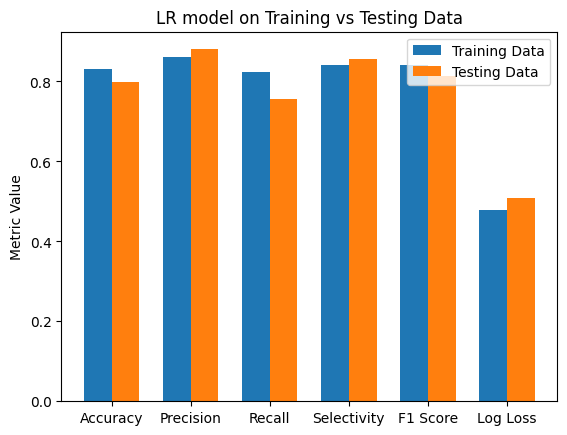

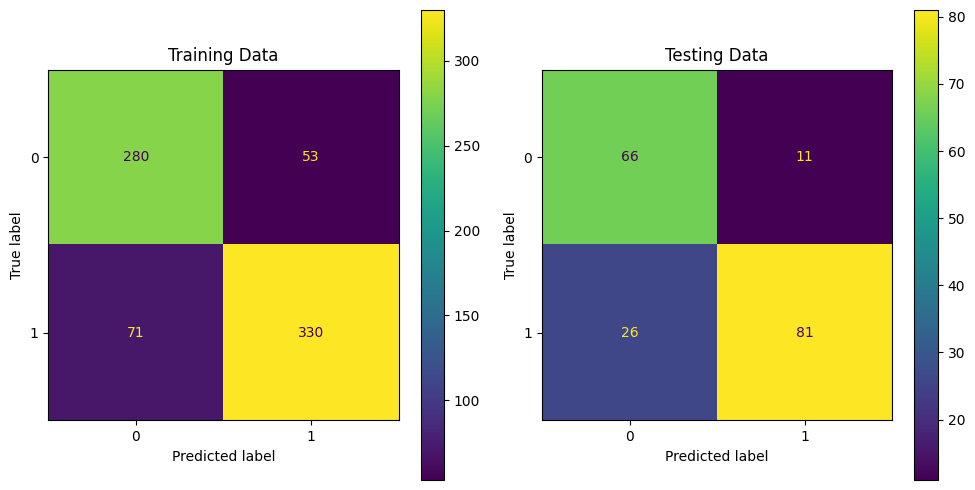

In [14]:
# list of metric names
metric_names = ['Accuracy', 'Precision', 'Recall', 'Selectivity', 'F1 Score', 'Log Loss']

# list of metric values
LR_model_train_metrics = [LR_model_train_accuracy, LR_model_train_precision, LR_model_train_recall, LR_model_train_selectivity, LR_model_train_f1, LR_model_train_log_loss]
LR_model_metrics = [LR_model_accuracy, LR_model_precision, LR_model_recall, LR_model_selectivity, LR_model_f1, LR_model_log_loss]


# create a bar chart
x = np.arange(len(metric_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, LR_model_train_metrics, width, label='Training Data')
rects2 = ax.bar(x + width/2, LR_model_metrics, width, label='Testing Data')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Value')
ax.set_title('LR model on Training vs Testing Data')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()

# Confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ConfusionMatrixDisplay(LR_model_train_cm).plot(ax=ax1)
ax1.set_title('Training Data')
ConfusionMatrixDisplay(LR_model_cm).plot(ax=ax2)
ax2.set_title('Testing Data')


# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()



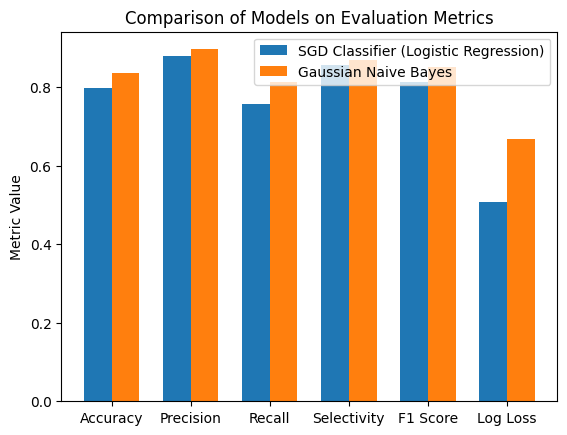

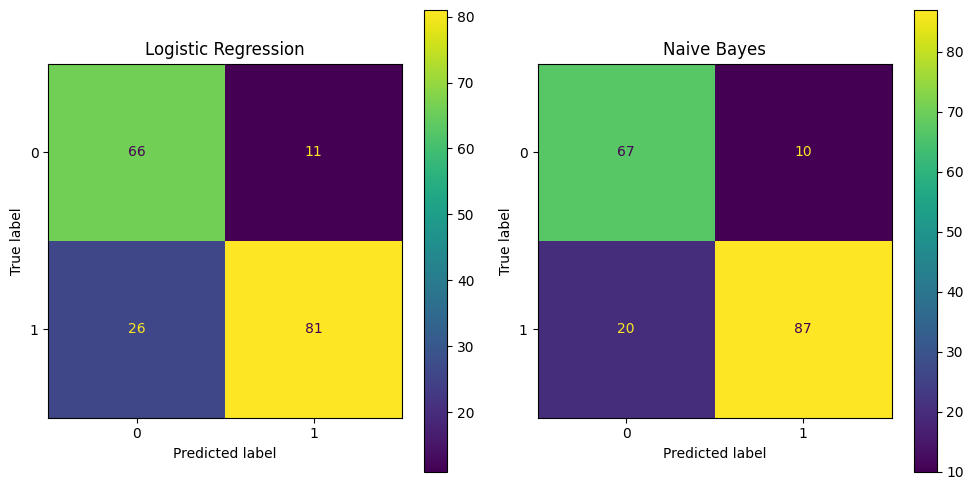

In [15]:

NB_model_metrics = [NB_model_accuracy, NB_model_precision, NB_model_recall, NB_model_selectivity, NB_model_f1, NB_model_log_loss]

# create a bar chart
x = np.arange(len(metric_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, LR_model_metrics, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, NB_model_metrics, width, label='Gaussian Naive Bayes')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Models on Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()

# Confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ConfusionMatrixDisplay(LR_model_cm).plot(ax=ax1)
ax1.set_title('Logistic Regression')
ConfusionMatrixDisplay(NB_model_cm).plot(ax=ax2)
ax2.set_title('Naive Bayes')

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()